# Parse Trajectory Information

In [1]:
import urllib.request,json
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
print ("Packages loaded.")

Packages loaded.


### Parse json 

In [2]:
MODE = 2
if MODE == 1:
    # From link
    page_link = 'http://sparklingmesh.iptime.org:10000/api/v1/position/list?id=1' # small data
    with urllib.request.urlopen(page_link) as url:
        s = url.read()
        json_parsed = json.loads(s)
    traj = json_parsed['data']
    L = len(traj)
    print ("L:[%d]"%(L))
elif MODE == 2:
    # From file
    file_path = '1620.json'
    f = open(file_path,)
    json_parsed = json.load(f)
    traj = json_parsed['data']
    L = len(traj)
    print ("L:[%d]"%(L))   

L:[1620]


### Parse time-stamped trajectory

In [3]:
xy_traj = np.zeros(shape=(L,2))
times = np.zeros(shape=(L))
for tick in range(L):
    p_t = traj[tick]
    x,y,sec_org = p_t['rX'],p_t['rY'],p_t['timestamp']/1000
    if tick == 0:
        sec_init = sec_org
    sec = sec_org - sec_init
    xy_traj[tick,0],xy_traj[tick,1],times[tick] = x,y,sec
    if tick == 0:
        sec_diff = 0
        xy_dist = 0
        vel = 0
    else:
        sec_diff = sec - sec_prev
        xy_dist = np.sqrt((x-x_prev)**2+(y-y_prev)**2)
        vel = xy_dist/sec_diff # m/s
    sec_prev,x_prev,y_prev = sec,x,y
    print ("tick:[%d] sec:[%.2f](diff:%.2f) xy:(%.2f,%.2f)(dist:%.2f, vel:%.2fm/s)"%
           (tick,sec,sec_diff,x,y,xy_dist,vel)) # print 

tick:[0] sec:[0.00](diff:0.00) xy:(18.44,29.95)(dist:0.00, vel:0.00m/s)
tick:[1] sec:[2.02](diff:2.02) xy:(18.51,30.02)(dist:0.11, vel:0.05m/s)
tick:[2] sec:[9.09](diff:7.07) xy:(19.34,30.17)(dist:0.84, vel:0.12m/s)
tick:[3] sec:[11.08](diff:2.00) xy:(19.34,30.17)(dist:0.00, vel:0.00m/s)
tick:[4] sec:[13.09](diff:2.01) xy:(18.44,29.72)(dist:1.01, vel:0.50m/s)
tick:[5] sec:[14.12](diff:1.03) xy:(18.21,29.72)(dist:0.23, vel:0.22m/s)
tick:[6] sec:[105.82](diff:91.70) xy:(18.24,29.81)(dist:0.10, vel:0.00m/s)
tick:[7] sec:[110.86](diff:5.04) xy:(18.24,29.81)(dist:0.00, vel:0.00m/s)
tick:[8] sec:[111.86](diff:1.00) xy:(18.24,29.81)(dist:0.00, vel:0.00m/s)
tick:[9] sec:[113.87](diff:2.01) xy:(18.24,29.81)(dist:0.00, vel:0.00m/s)
tick:[10] sec:[115.91](diff:2.04) xy:(18.24,29.81)(dist:0.00, vel:0.00m/s)
tick:[11] sec:[117.91](diff:2.01) xy:(18.92,30.49)(dist:0.95, vel:0.48m/s)
tick:[12] sec:[118.92](diff:1.01) xy:(18.92,30.94)(dist:0.45, vel:0.45m/s)
tick:[13] sec:[119.94](diff:1.02) xy:(18.05

tick:[1468] sec:[4965.98](diff:1.02) xy:(18.33,30.53)(dist:0.95, vel:0.94m/s)
tick:[1469] sec:[4968.98](diff:3.01) xy:(18.33,30.76)(dist:0.23, vel:0.07m/s)
tick:[1470] sec:[4970.99](diff:2.01) xy:(18.55,30.83)(dist:0.24, vel:0.12m/s)
tick:[1471] sec:[4972.01](diff:1.03) xy:(18.40,30.88)(dist:0.16, vel:0.16m/s)
tick:[1472] sec:[4974.01](diff:2.00) xy:(19.53,32.00)(dist:1.59, vel:0.80m/s)
tick:[1473] sec:[4975.01](diff:1.00) xy:(19.31,32.11)(dist:0.24, vel:0.24m/s)
tick:[1474] sec:[4977.05](diff:2.03) xy:(19.76,32.06)(dist:0.45, vel:0.22m/s)
tick:[1475] sec:[4980.06](diff:3.01) xy:(20.21,31.61)(dist:0.64, vel:0.21m/s)
tick:[1476] sec:[4981.06](diff:1.00) xy:(19.98,31.16)(dist:0.50, vel:0.50m/s)
tick:[1477] sec:[4982.09](diff:1.03) xy:(19.08,30.71)(dist:1.01, vel:0.98m/s)
tick:[1478] sec:[4983.09](diff:1.00) xy:(19.76,30.94)(dist:0.71, vel:0.71m/s)
tick:[1479] sec:[4984.09](diff:1.00) xy:(19.08,31.39)(dist:0.81, vel:0.81m/s)
tick:[1480] sec:[4985.11](diff:1.02) xy:(20.63,31.81)(dist:1.60,

### Plot trajectory

In [4]:
import matplotlib.collections as mcoll
import matplotlib.path as mpath
def colorline(
    x, y, z=None, cmap=plt.get_cmap('jet'), norm=plt.Normalize(0.0, 1.0),
        linewidth=3, alpha=1.0):
    """
    http://nbviewer.ipython.org/github/dpsanders/matplotlib-examples/blob/master/colorline.ipynb
    http://matplotlib.org/examples/pylab_examples/multicolored_line.html
    Plot a colored line with coordinates x and y
    Optionally specify colors in the array z
    Optionally specify a colormap, a norm function and a line width
    """
    # Default colors equally spaced on [0,1]:
    if z is None:
        z = np.linspace(0.0, 1.0, len(x))
    # Special case if a single number:
    if not hasattr(z, "__iter__"):  # to check for numerical input -- this is a hack
        z = np.array([z])
    z = np.asarray(z)
    segments = make_segments(x, y)
    lc = mcoll.LineCollection(segments, array=z, cmap=cmap, norm=norm,
                              linewidth=linewidth, alpha=alpha)
    ax = plt.gca()
    ax.add_collection(lc)
    return lc
def make_segments(x, y):
    """
    Create list of line segments from x and y coordinates, in the correct format
    for LineCollection: an array of the form numlines x (points per line) x 2 (x
    and y) array
    """
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    return segments
print ("Done.")

Done.


### Plot trajectory

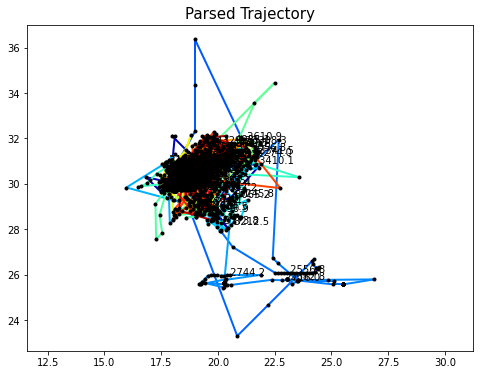

In [5]:
plt.figure(figsize=(8,6))
plt.plot(xy_traj[:,0],xy_traj[:,1],'ko',markersize=3)
colorline(xy_traj[:,0],xy_traj[:,1],np.linspace(0,1,L),linewidth=2)
for tick in range(L):
    if (tick%20) == 0:
        plt.text(xy_traj[tick,0],xy_traj[tick,1],
                 ' %.1f'%times[tick],fontsize=10)
plt.title('Parsed Trajectory',fontsize=15)
plt.axis('equal')
plt.show()

### Make heatmap of the raw trajectory

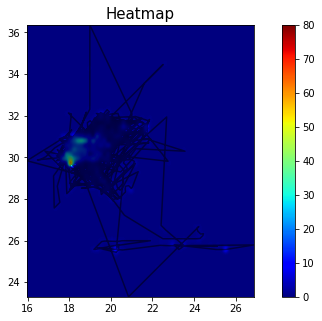

In [6]:
from matplotlib import cm
heatmap,xedges,yedges = np.histogram2d(xy_traj[:,0],xy_traj[:,1], bins=(60,60))
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
plt.figure(figsize=(10,5))
plt.plot(xy_traj[:,0],xy_traj[:,1],'k-',alpha=0.5)
plt.imshow(heatmap.T,extent=extent,origin='lower',cmap=cm.jet,
          interpolation='gaussian')
plt.colorbar()
plt.title('Heatmap',fontsize=15)
plt.show()

### Kalman Filter (not used for now)

In [7]:
class KalmanFilterClass(object):
    def __init__(self,name='kf',dt=0.05,q_x=0.1,q_v=0.1,r_y=1.0,y_init=0.0):
        self.name = name
        self.dt = dt
        self.q_x = q_x
        self.q_v = q_v
        self.r_y = r_y
        self.y_init = y_init
        # Initialize some internal variables
        self.Q = np.array([[self.q_x,0],[0,self.q_v]])
        self.R = np.array(self.r_y)
        self.H = np.array([[1,0]])
        self.F = np.array([[1,self.dt],[0,1]])
        #
        self.x_hat = np.array([[self.y_init],[0]])
        self.P_hat = self.Q
        self.y = self.y_init
        
    # Update Kalman Filter
    def update(self,y):
        x_hat_m = np.matmul(self.F,self.x_hat)
        P_hat_m = np.matmul(np.matmul(self.F,self.P_hat),self.F.T) + self.Q
        W = np.linalg.inv(np.matmul(np.matmul(self.H,P_hat_m),self.H.T)+self.R)
        K = np.matmul(np.matmul(P_hat_m, self.H.T),W)
        # Update
        self.x_hat = self.x_hat + np.matmul(K,y-np.matmul(self.H,x_hat_m))
        self.P_hat = P_hat_m - np.matmul(np.matmul(K,self.H),P_hat_m)
print ("Done.")

Done.


In [8]:
DO_KF = False
# Kalman filtering 
if DO_KF: # optional
    dt,q_x,q_v,r_y = 0.25,1.0,0.5,2.0
    K_x = KalmanFilterClass(
        name='x',dt=dt,q_x=q_x,q_v=q_v,r_y=r_y,y_init=xy_traj[tick,0])
    K_y = KalmanFilterClass(
        name='y',dt=dt,q_x=q_x,q_v=q_v,r_y=r_y,y_init=xy_traj[tick,1])
    xy_traj_filtered = np.zeros(shape=(L,2))
    for tick in range(L):
        # Kalman filter
        K_x.update(y=xy_traj[tick,0])
        K_y.update(y=xy_traj[tick,1])
        # Use predicted position
        x_filtered = K_x.x_hat[0] + K_x.x_hat[1]*K_x.dt
        y_filtered = K_y.x_hat[0] + K_y.x_hat[1]*K_y.dt
        xy_traj_filtered[tick,0],xy_traj_filtered[tick,1] = x_filtered,y_filtered
    print ("Filtered")

    # - Plot - 
    plt.figure(figsize=(8,6))
    plt.plot(xy_traj[:,0],xy_traj[:,1],'ko-')
    plt.plot(xy_traj_filtered[:,0],xy_traj_filtered[:,1],'b-')
    plt.axis('equal')
    plt.title('Parsed Trajectory',fontsize=15)
    plt.show()

### Smooth trajectory using Gaussian Random Path

In [9]:
HZ = len(times)/(times[-1]-times[0])
print ("N:[%d] time:[%.1f]~[%.1f] HZ:[%.3f]"%
       (len(times),times[0],times[-1],HZ))

N:[1620] time:[0.0]~[5258.5] HZ:[0.308]


In [10]:
import time
from scipy.spatial.distance import pdist, squareform, cdist

def kernel_se(t1,t2,hyp={'gain':1,'len':1,'noise':1e-8}):
    hyp_gain = float(hyp['gain'])**2
    hyp_len  = float(hyp['len'])
    if len(t1.shape)<=1: t1=t1.reshape((-1,1))
    if len(t2.shape)<=1: t2=t2.reshape((-1,1))
    D = cdist(t1,t2,'euclidean')
    K = hyp_gain*np.exp(-D**2 / (hyp_len**2))
    if t1.shape[0] == t2.shape[0]:
        K = K + hyp['noise']*np.eye(t1.shape[0])
    return K

def grp_mu(t_in,x_in,t_test,hyp):
    k_test_in = kernel_se(t_test,t_in,hyp=hyp)
    K_in_in = kernel_se(t_in,t_in,hyp=hyp) # n_data x n_data
    x_in_mean = x_in.mean(axis=0)
    mu_test = np.matmul(
        k_test_in,
        np.linalg.solve(K_in_in,x_in-x_in_mean))+x_in_mean
    return mu_test

# Smooth using GRP
start_time = time.time()
t_start,t_final,smoothing_HZ = np.min(times),np.max(times),2
t_test = np.linspace(start=t_start,stop=t_final,num=round(t_final-t_start)*smoothing_HZ)
n_anchor,n_test = times.shape[0],t_test.shape[0]
print ("n_anchor:[%d] n_test:[%d]."%(n_anchor,n_test))

n_anchor:[1620] n_test:[10516].


In [11]:
# If 'n_test' is too big, then reduce the 'smoothing_HZ'
n_test_max = 10000
if n_test > n_test_max:
    smoothing_HZ = n_test_max/(t_final-t_start)
    print ("n_test [%d]=>[%d] smoothing_HZ:[%.2f]"%(n_test,n_test_max,smoothing_HZ))
    n_test = n_test_max
    t_test = np.linspace(start=t_start,stop=t_final,num=n_test)
else:
    print ("n_test:[%d] is good enough."%(n_test))

n_test [10516]=>[10000] smoothing_HZ:[1.90]


In [12]:
# Divide-and-conquer GP interpolation to handle too big 'n_anchor'
start_time = time.time()
hyp = {'gain':1,'len':2,'noise':5e-1} # hyperparameter for smoothing
n_batch = 500 # batch_size
n_iter = (n_anchor // n_batch)+1 # number of iterations
print ("n_anchor:[%d] n_test:[%d] n_iter:[%d]"%(n_anchor,n_test,n_iter))
print (" anchor times:[%.2f]sec~[%.2f]sec (n:[%d])"%(times[0],times[-1],times.shape[0]))
print (" test times:[%.2f]sec~[%.2f]sec (n:[%d])"%(t_test[0],t_test[-1],t_test.shape[0]))
print ("")
xy_smoothed = np.zeros(shape=(n_test,2))
for i_idx in range(n_iter):
    start_anchor_idx,end_anchor_idx = i_idx*n_batch,min(i_idx*n_batch+n_batch,n_anchor)
    # Get the corresponding 'start_anchor_sec' and 'end_anchor_sec' 
    start_anchor_sec,end_anchor_sec = times[start_anchor_idx],times[end_anchor_idx-1]
    # Then, find the corresponding 'start_test_sec' and 'end_test_sec' in 't_test'
    if i_idx == 0: # first iter
        start_test_idx = 0
        end_test_idx = np.argmin(np.abs(t_test-end_anchor_sec))
    elif i_idx == (n_iter-1): # last iter
        start_test_idx = end_test_idx_prev
        end_test_idx = n_test
    else: 
        start_test_idx = end_test_idx_prev
        end_test_idx = np.argmin(np.abs(t_test-end_anchor_sec))
    end_test_idx_prev = end_test_idx
    # Finally, get the corresponding 'start_test_sec' and 'end_test_sec' 
    start_test_sec,end_test_sec = t_test[start_test_idx],t_test[end_test_idx-1]
    
    # Smoothing
    xy_smoothed[start_test_idx:end_test_idx,0] = grp_mu(
        times[start_anchor_idx:end_anchor_idx],
        xy_traj[start_anchor_idx:end_anchor_idx,0],
        t_test[start_test_idx:end_test_idx],
        hyp)
    xy_smoothed[start_test_idx:end_test_idx,1] = grp_mu(
        times[start_anchor_idx:end_anchor_idx],
        xy_traj[start_anchor_idx:end_anchor_idx,1],
        t_test[start_test_idx:end_test_idx],
        hyp)
    
    # Print out
    print ("dnq:[%d/%d]\n start_anchor_idx:[%d]~end_anchor_idx:[%d]"%
           (i_idx,n_iter,start_anchor_idx,end_anchor_idx))
    print (" start_anchor_sec:[%.2f]sec~end_anchor_sec:[%.2f]sec"%
           (start_anchor_sec,end_anchor_sec))
    print (" start_test_idx:[%d]sec~end_test_idx:[%d]sec"%
           (start_test_idx,end_test_idx))
    print (" start_test_sec:[%.2f]sec~end_test_sec:[%.2f]sec"%
           (start_test_sec,end_test_sec))
    print ("")
esec = time.time()-start_time    
print ("GP smoothing (n_anchor:[%d] n_test:[%d]) takes [%.4f]sec."%(n_anchor,n_test,esec))

n_anchor:[1620] n_test:[10000] n_iter:[4]
 anchor times:[0.00]sec~[5258.48]sec (n:[1620])
 test times:[0.00]sec~[5258.48]sec (n:[10000])

dnq:[0/4]
 start_anchor_idx:[0]~end_anchor_idx:[500]
 start_anchor_sec:[0.00]sec~end_anchor_sec:[3141.79]sec
 start_test_idx:[0]sec~end_test_idx:[5974]sec
 start_test_sec:[0.00]sec~end_test_sec:[3141.21]sec

dnq:[1/4]
 start_anchor_idx:[500]~end_anchor_idx:[1000]
 start_anchor_sec:[3143.82]sec~end_anchor_sec:[4063.51]sec
 start_test_idx:[5974]sec~end_test_idx:[7727]sec
 start_test_sec:[3141.73]sec~end_test_sec:[4063.11]sec

dnq:[2/4]
 start_anchor_idx:[1000]~end_anchor_idx:[1500]
 start_anchor_sec:[4064.52]sec~end_anchor_sec:[5022.44]sec
 start_test_idx:[7727]sec~end_test_idx:[9550]sec
 start_test_sec:[4063.64]sec~end_test_sec:[5021.83]sec

dnq:[3/4]
 start_anchor_idx:[1500]~end_anchor_idx:[1620]
 start_anchor_sec:[5023.45]sec~end_anchor_sec:[5258.48]sec
 start_test_idx:[9550]sec~end_test_idx:[10000]sec
 start_test_sec:[5022.35]sec~end_test_sec:[5258

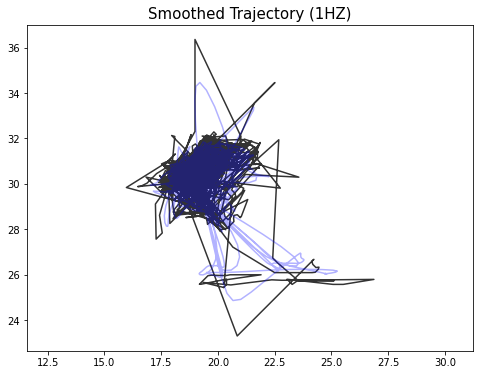

Simple trajectory plot takes [0.1505]sec.


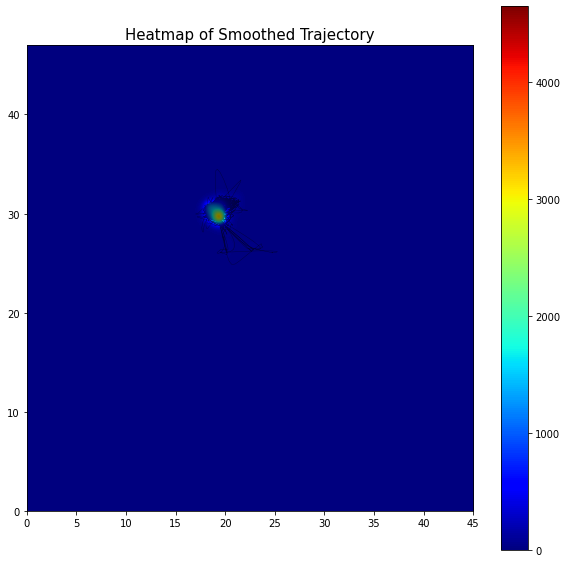

Heatmap plot takes [0.2781]sec.


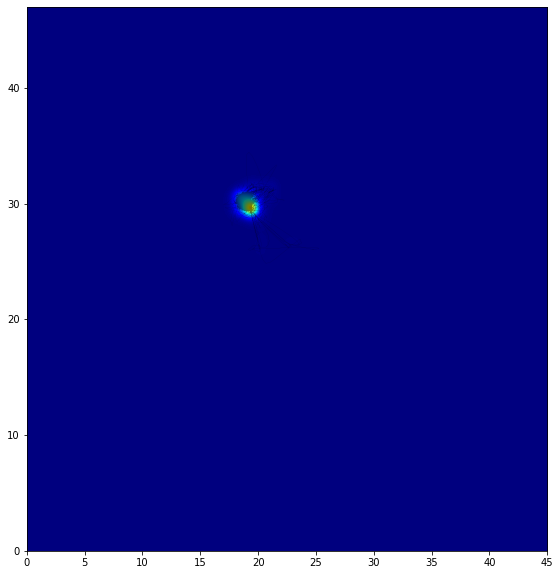

Heatmap plot takes [0.2557]sec.


In [13]:
# Batch smoothing
"""
hyp = {'gain':1,'len':2,'noise':5e-1} # hyperparameter
xy_smoothed = np.zeros(shape=(t_test.shape[0],2))
xy_smoothed[:,0] = grp_mu(times,xy_traj[:,0],t_test,hyp)
xy_smoothed[:,1] = grp_mu(times,xy_traj[:,1],t_test,hyp)
"""

# Plot the original and smoothed trajectory
start_time = time.time()
plt.figure(figsize=(8,6))
plt.plot(xy_traj[:,0],xy_traj[:,1],'k-',alpha=0.8)
plt.plot(xy_smoothed[:,0],xy_smoothed[:,1],'b-',alpha=0.3)
plt.axis('equal')
plt.title('Smoothed Trajectory (%dHZ)'%(smoothing_HZ),fontsize=15)
plt.show()
esec = time.time()-start_time
print ("Simple trajectory plot takes [%.4f]sec."%(esec))

# Plot heatmap
start_time = time.time()
heatmap,xedges,yedges = np.histogram2d(xy_smoothed[:,0],xy_smoothed[:,1],bins=(50,50),
                                      range=[[0, 45], [0, 47]])
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
plt.figure(figsize=(10,10))
plt.plot(xy_smoothed[:,0],xy_smoothed[:,1],'k-',alpha=0.5,lw=0.4)
plt.imshow(heatmap.T,extent=extent,origin='lower',cmap=cm.jet,
          interpolation='gaussian')
plt.colorbar(); 
plt.title('Heatmap of Smoothed Trajectory',fontsize=15); plt.show()
esec = time.time()-start_time
print ("Heatmap plot takes [%.4f]sec."%(esec))

# Another heatmap without colorbar
start_time = time.time()
plt.figure(figsize=(10,10))
plt.plot(xy_smoothed[:,0],xy_smoothed[:,1],'k-',alpha=0.5,lw=0.1)
plt.imshow(heatmap.T,extent=extent,origin='lower',cmap=cm.jet,interpolation='gaussian')
plt.xlim(left=None,right=45)
plt.ylim(bottom=None,top=47)
# plt.axis('off') # to remove axis
plt.show()
esec = time.time()-start_time
print ("Heatmap plot takes [%.4f]sec."%(esec))

### Make features

==== Booth visit frequency feature ====
	Booth[0]	Booth[1]	Booth[2]	Booth[3]	Booth[4]	
<1.0m 	 0.00    	 0.00    	 0.00    	 0.00    	 0.00    	
<2.0m 	 0.00    	 0.00    	 0.00    	 0.00    	 0.00    	
<3.0m 	 0.00    	 0.00    	 0.00    	 0.00    	 0.00    	
<4.0m 	 0.00    	 0.00    	 0.00    	 0.00    	 0.00    	


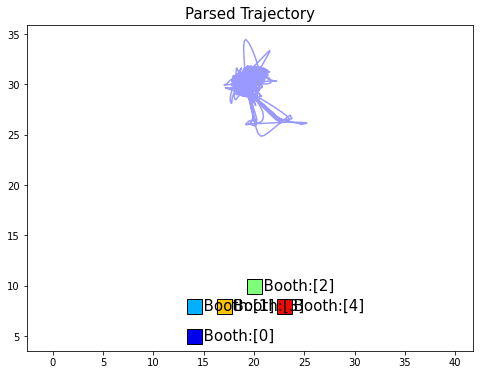

In [14]:
np.set_printoptions(precision=2)
# Set booth locations
booth_xys = np.array([[14,5],[14,8],[20,10],[17,8],[23,8]])

# Distance thresholds
d_ths = [1,2,3,4]

# Feature representation
n_booth = booth_xys.shape[0] # number of booths
n_th = len(d_ths) # number of thresholds
feature = np.zeros(shape=(n_booth,n_th)) # feature


# Loop
L_smoothed = xy_smoothed.shape[0]
for tick in range(L_smoothed): # for all ticks
    xy_t = xy_smoothed[tick] 
    for b_idx in range(n_booth): # for all booths 
        booth_xy_b = booth_xys[b_idx]
        dist_b = np.linalg.norm(xy_t-booth_xy_b) # distance to booth
        for d_idx in range(n_th): # for different distance thresholds
            d_th = d_ths[d_idx]
            if dist_b < d_th:
                feature[b_idx,d_idx] = feature[b_idx,d_idx] + 1
        VERBOSE = False
        if VERBOSE:
            print ("tick:[%d] b_idx:[%d] xy_t:%s booth_xy:%s dist_b:[%.2f]"%
                   (tick,b_idx,xy_t,booth_xy_b,dist_b))
# Normalize
feature = feature / L_smoothed

# Printout feature information
print ("==== Booth visit frequency feature ====")
print ("\t",end= '')
for b_idx in range(n_booth):
    print ("Booth[%d]\t"%(b_idx),end= '')
print ("")
for d_idx in range(n_th):    
    d_th = d_ths[d_idx]
    print ("<%.1fm \t"%(d_th),end= '')
    for b_idx in range(n_booth):
        freq = feature[b_idx,d_idx]
        print (" %.2f    \t"%(freq),end= '')
    print ("") 
    
# Plot trajectory with booths
plt.figure(figsize=(8,6))
colors = plt.cm.jet(np.linspace(0.1,0.9,n_booth))
for b_idx in range(n_booth):
    color = colors[b_idx]
    plt.plot(booth_xys[b_idx,0],booth_xys[b_idx,1],marker='s',
             color='k',mfc=color,ms=15,lw=5)
    plt.text(booth_xys[b_idx,0],booth_xys[b_idx,1],
             '  Booth:[%d]'%(b_idx),fontsize=15,va='center')
# plt.plot(xy_traj_filtered[:,0],xy_traj_filtered[:,1],'k-',alpha=0.1)
plt.plot(xy_smoothed[:,0],xy_smoothed[:,1],'b-',alpha=0.4)
plt.axis('equal')
plt.title('Parsed Trajectory',fontsize=15)
plt.show()